# Import Modules 

In [2]:
# utilities
import re
import numpy as np
import pandas as pd
import glob
import os
import string
import itertools
import unidecode
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Upload data

In [70]:
path = r'dilma/' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f) for f in all_files)
df   = pd.concat(df_from_each_file, ignore_index=True)
df=df[df["lang"]=="pt"]

In [4]:
df_ts = df.copy()

In [71]:
df.columns

Index(['Unnamed: 0', 'url', 'date', 'content', 'id', 'reply_count',
       'retweet_count', 'like_count', 'quote_count', 'lang', 'username',
       'displayname', 'description', 'verified', 'created', 'followers_count',
       'friends_count', 'location', 'protected', 'profile_img', 'query',
       'crawled_date', 'VADAR', 'compound', 'sentiment'],
      dtype='object')

In [72]:
df.followers_count.describe()

count    4.251890e+05
mean     4.760293e+04
std      4.934433e+05
min      0.000000e+00
25%      1.570000e+02
50%      6.070000e+02
75%      2.311000e+03
max      2.167983e+07
Name: followers_count, dtype: float64

In [73]:
df.corr()

,Unnamed: 0,id,reply_count,retweet_count,like_count,quote_count,verified,followers_count,friends_count,protected,compound
Unnamed: 0,1.000000,-0.060407,-0.046905,-0.021220,-0.030911,-0.003721,-0.016049,-0.083985,-0.012946,NaN,0.023138
id,-0.060407,1.000000,0.003763,0.004622,0.009072,0.000225,-0.012150,0.009856,-0.035230,NaN,0.012525
reply_count,-0.046905,0.003763,1.000000,0.778211,0.822136,0.460651,0.223510,0.423242,-0.000845,NaN,0.003917
retweet_count,-0.021220,0.004622,0.778211,1.000000,0.984284,0.844116,0.106208,0.195731,0.001071,NaN,-0.001109
like_count,-0.030911,0.009072,0.822136,0.984284,1.000000,0.792496,0.149754,0.282363,-0.000764,NaN,0.001610
quote_count,-0.003721,0.000225,0.460651,0.844116,0.792496,1.000000,0.024435,0.039756,-0.000800,NaN,-0.002098
verified,-0.016049,-0.012150,0.223510,0.106208,0.149754,0.024435,1.000000,0.570227,0.004100,NaN,0.017357
followers_count,-0.083985,0.009856,0.423242,0.195731,0.282363,0.039756,0.570227,1.000000,0.027713,NaN,0.012799
friends_count,-0.012946,-0.035230,-0.000845,0.001071,-0.000764,-0.000800,0.004100,0.027713,1.000000,NaN,-0.023354
protected,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df[['sentiment','id','date','query','username','content']]

In [5]:
df.rename(columns={'sentiment':'target','id':'ids','query':'flag','username':'user','content':'text'}, inplace=True)

In [6]:
df = df.loc[(df['target']=='pos')| (df['target']=='neg')]
df.shape

(269812, 6)

<AxesSubplot:xlabel='target', ylabel='count'>

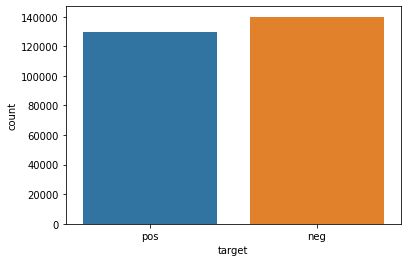

In [7]:
import seaborn as sns
sns.countplot(x='target', data=df)

# Sanitizing the data 

In [8]:
def clean_tweet(tweet):

    tweet = tweet.lower()
    tweet = re.sub(r"\d+", "", tweet)
    tweet = re.sub(r'\@[a-zA-Z0-9]*', ' ', tweet) # remove username start with @
    tweet = re.sub(r'https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet) # remove link in the tweet
    tweet = re.sub(r'\$[a-zA-Z0-9]*', ' ', tweet) # remove the variable start with $
    #tweet = re.sub('[^a-zA-Z\']', ' ', tweet)
    for punctuation in new_punc: # remove panctuations 
            tweet = tweet.replace(punctuation, '')
    tweet = ' '.join( [w for w in tweet.split() if len(w)>1] ) #remove one letter words
    tweet = ''.join(c[0] for c in itertools.groupby(tweet)) #remove duplicated letters
    tweet = unidecode.unidecode(tweet)  # normalizar as letras com acentos 
    tweet = ' '.join(word for word in tweet.split(' ') if word not in stop_words) # remove stopwords
    
    return tweet 

In [9]:
%%time
new_punc = list(string.punctuation)
del new_punc[2]
stop_words = stopwords.words('portuguese')
#stop_words.remove('não')
addicional = [
            'd', 'ta', 'q', 'tah', 'tao', 'eh', 'vc', 'voce',
            'pq', 'quede', 'mto', 'mt', 'bj', 'bjs','vcs','bb','pra','ai',
            'b', 'sao', 'axo', 'mano', 'ae', 'neh', 'ai','la','ja','so',
            'porque', 'ne', 'no', 'iai', 'tbm', 'msm', 'jah', 'yahoo', 'yahoobr','rt']
stop_words.extend(addicional)
df['text'] = df['text'].astype(str)
df["clean_text"]=df["text"].apply(lambda x:clean_tweet(x))
df = df.drop_duplicates(subset="clean_text",keep="first")
df['date'] = pd.to_datetime(df['date'])
df

CPU times: user 19.7 s, sys: 82.2 ms, total: 19.8 s
Wall time: 19.8 s


,target,ids,date,flag,user,text,clean_text
0,pos,465487067477463040,2014-05-11 13:42:19,(from:dilmabr),dilmabr,"Uma data para marcar o reconhecimento, o carin...",data marcar reconhecimento carinho respeito ma...
2,pos,465486889278246913,2014-05-11 13:41:37,(from:dilmabr),dilmabr,Hoje envio um abraço cheio de alegria a todas ...,hoje envio abraco cheio alegria todas maes bra...
4,neg,498096383187255296,2014-08-09 13:20:06,(from:dilmabr),dilmabr,"Para quem não está em Osasco, a caminhada será...",nao osasco caminhada sera transmitida vivo #ma...
6,pos,468855265400725506,2014-05-20 20:46:20,(from:dilmabr),dilmabr,A Orquestra Pimentinhas executou o hino nacion...,orquestra pimentinhas executou hino nacional g...
8,neg,468853624412864512,2014-05-20 20:39:49,(from:dilmabr),dilmabr,Esse novo terminal fará a capacidade do aeropo...,ese novo terminal fara capacidade aeroporto #g...
...,...,...,...,...,...,...,...
427948,neg,509495173802647553,2014-09-10 00:14:50,(to:dilmabr),JCRuckill,"@dilmabr Roubar dinheiro de pobre é feio, viu???",roubar dinheiro pobre feio viu
427949,neg,509494984073281537,2014-09-10 00:14:04,(to:dilmabr),JCRuckill,"@dilmabr R$ 3.125,00 para colocar laquê no cap...",colocar laque capacete dinheiro povo eta esque...
427950,pos,509494784147619840,2014-09-10 00:13:17,(to:dilmabr),JCRuckill,@dilmabr Eta esquerda de meia tigela que gosta...,eta esquerda meia tigela gosta dinheirinho out...
427951,neg,509494431918329857,2014-09-10 00:11:53,(to:dilmabr),LFDivulga,@dilmabr NÃO IRIA MELHORAR A INTERNET DO BRASI...,nao iria melhorar internet brasil ah pois nao ...


In [10]:
df["clean_text"]=df["clean_text"].apply(lambda x: x.split())

In [11]:
df['target'] = df['target'].apply(lambda x: 1 if x=='pos' else -1)

# WordCloud of Positive and Negative tweets

In [12]:
data_neg = df.loc[df['target']==-1, 'clean_text']
neg_sentences=[]
for sentences in data_neg[:]:
    for word in sentences:
        neg_sentences.append(word)

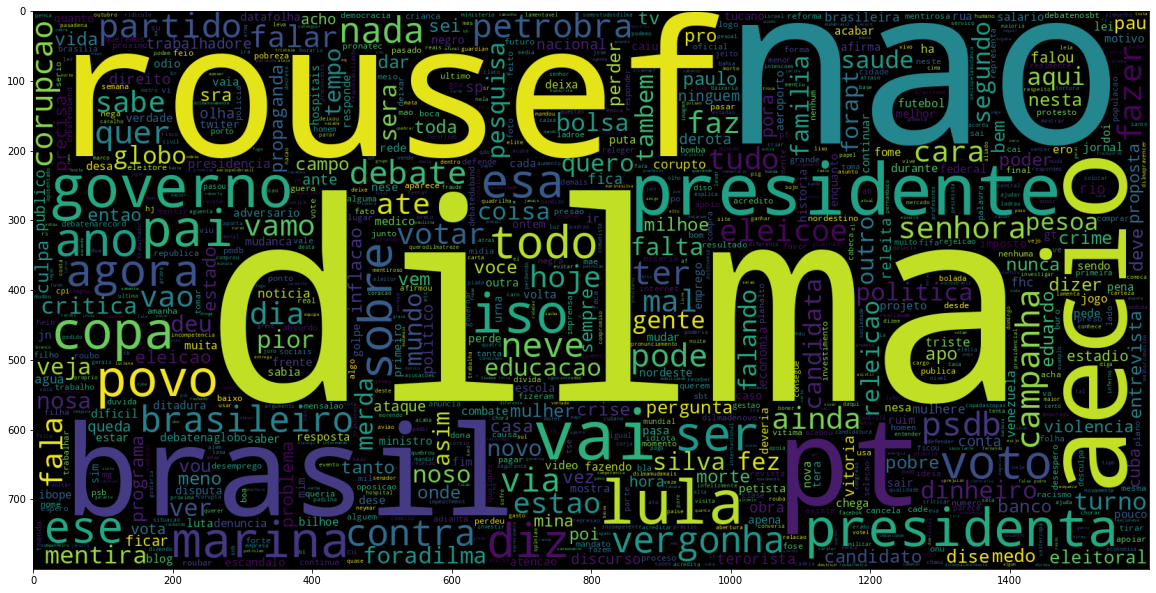

In [13]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neg_sentences))
plt.imshow(wc)

In [14]:
data_pos = df.loc[df['target']==1, 'clean_text']
pos_sentences=[]
for sentences in data_pos[:]:
    for word in sentences:
        pos_sentences.append(word)

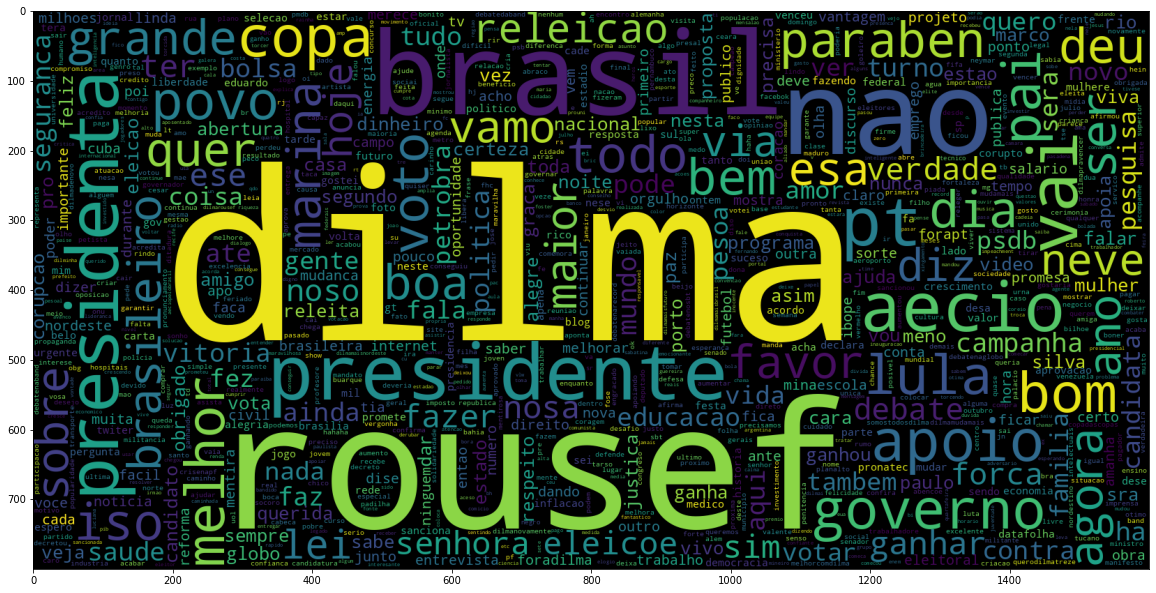

In [15]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(pos_sentences))
plt.imshow(wc)

# Create baseline model, logistic and SVC 

In [16]:
X=df.text
y=df.target

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state =42)


In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [19]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

LinearSVC()

## Model Evaluation 

In [20]:
y_pred = SVCmodel.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

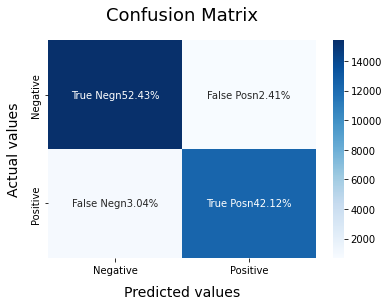

In [21]:
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

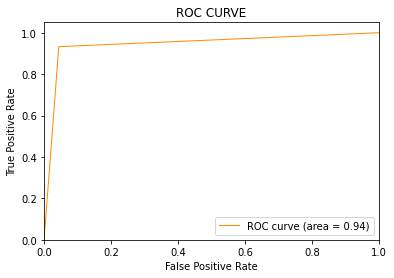

In [22]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [23]:
Logistic_model = LogisticRegression(max_iter=1000)
Logistic_model.fit(X_train, y_train)
y_pred = Logistic_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

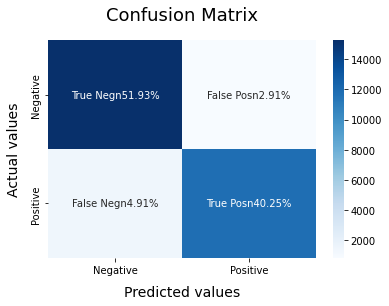

In [24]:
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

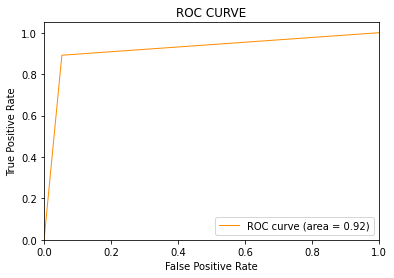

In [25]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# SVM Model 

In [6]:
dfts = df_ts[['date','compound']]
dfts['date'] = pd.to_datetime(df['date'])
dfts['compound'] = df['compound'].astype(float)
dfts.set_index('date', inplace=True)
df_avg = dfts.resample('D').mean()


/tmp/ipykernel_4621/3011284460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfts['date'] = pd.to_datetime(df['date'])
/tmp/ipykernel_4621/3011284460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfts['compound'] = df['compound'].astype(float)


In [61]:
df.columns

Index(['Unnamed: 0', 'url', 'date', 'content', 'id', 'reply_count',
       'retweet_count', 'like_count', 'quote_count', 'lang', 'username',
       'displayname', 'description', 'verified', 'created', 'followers_count',
       'friends_count', 'location', 'protected', 'profile_img', 'query',
       'crawled_date', 'VADAR', 'compound', 'sentiment'],
      dtype='object')

In [30]:
df_ts.columns
df_ts['importancia'] = (df_ts.reply_count+df_ts.retweet_count+df_ts.like_count)/3
df_ts['avg_weighted'] = df_ts['importancia'] * df_ts['compound'] 
df_ts['avg_weighted']

0          74.537633
1           0.000000
2         122.382000
3           0.000000
4          -2.459600
             ...    
427950      0.000000
427951     -0.000000
427952      0.307233
427953      0.000000
427954     -0.000000
Name: avg_weighted, Length: 425189, dtype: float64

In [63]:
dfts = df_ts[['date','avg_weighted', 'reply_count', 'retweet_count', 'like_count']]
dfts['date'] = pd.to_datetime(df['date'])
dfts['avg_weighted'] = df_ts['avg_weighted'].astype(float)
dfts.set_index('date', inplace=True)
df_avg = dfts.resample('D').mean()

/tmp/ipykernel_4621/4256056849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfts['date'] = pd.to_datetime(df['date'])
/tmp/ipykernel_4621/4256056849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfts['avg_weighted'] = df_ts['avg_weighted'].astype(float)


<AxesSubplot:>

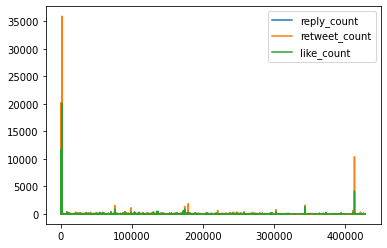

In [66]:
df_ts[['reply_count', 'retweet_count', 'like_count']].plot()

In [67]:
df_ts.corr()

,Unnamed: 0,id,reply_count,retweet_count,like_count,quote_count,verified,followers_count,friends_count,protected,compound,importancia,avg_weighted
Unnamed: 0,1.000000,-0.060407,-0.046905,-0.021220,-0.030911,-0.003721,-0.016049,-0.083985,-0.012946,NaN,0.023138,-0.026837,0.000457
id,-0.060407,1.000000,0.003763,0.004622,0.009072,0.000225,-0.012150,0.009856,-0.035230,NaN,0.012525,0.006168,0.000851
reply_count,-0.046905,0.003763,1.000000,0.778211,0.822136,0.460651,0.223510,0.423242,-0.000845,NaN,0.003917,0.823493,-0.511597
retweet_count,-0.021220,0.004622,0.778211,1.000000,0.984284,0.844116,0.106208,0.195731,0.001071,NaN,-0.001109,0.995614,-0.696247
like_count,-0.030911,0.009072,0.822136,0.984284,1.000000,0.792496,0.149754,0.282363,-0.000764,NaN,0.001610,0.994872,-0.658527
quote_count,-0.003721,0.000225,0.460651,0.844116,0.792496,1.000000,0.024435,0.039756,-0.000800,NaN,-0.002098,0.812604,-0.507773
verified,-0.016049,-0.012150,0.223510,0.106208,0.149754,0.024435,1.000000,0.570227,0.004100,NaN,0.017357,0.131782,-0.002172
followers_count,-0.083985,0.009856,0.423242,0.195731,0.282363,0.039756,0.570227,1.000000,0.027713,NaN,0.012799,0.245900,-0.002210
friends_count,-0.012946,-0.035230,-0.000845,0.001071,-0.000764,-0.000800,0.004100,0.027713,1.000000,NaN,-0.023354,0.000316,-0.000157
protected,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='date'>

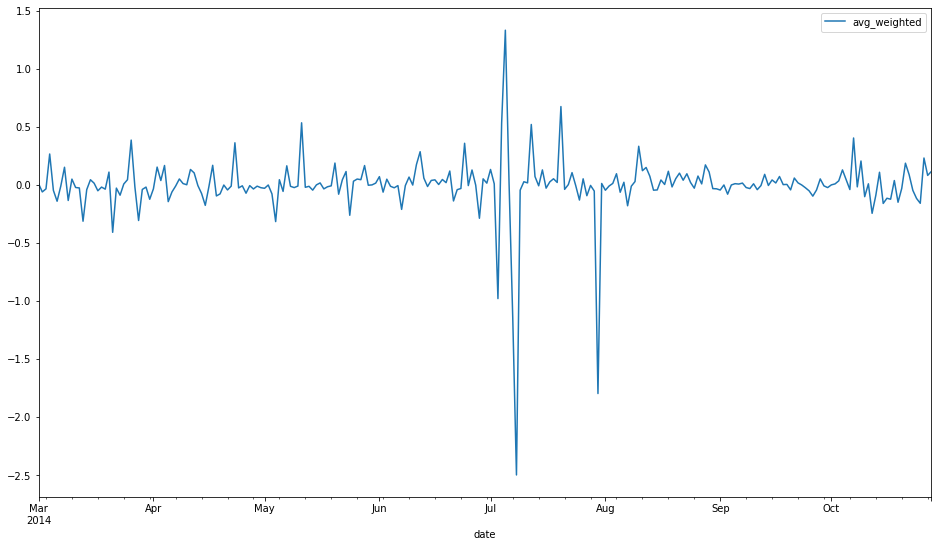

In [54]:
df_avg['avg_weighted'].plot(legend=True,figsize=(16,9))

In [69]:
df_avg['avg_weighted'].describe()

count    242.000000
mean      -0.002085
std        0.270211
min       -2.495725
25%       -0.036636
50%        0.001960
75%        0.053387
max        1.335855
Name: avg_weighted, dtype: float64

In [34]:
import pmdarima as pm
smodel = pm.auto_arima(df_avg['avg_weighted'],
                       start_p=1, max_p=5,
                       start_q=1, max_q=5,
                       trend='t',
                       seasonal=False,
                       test='adf',
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=50.509, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56.440, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=49.761, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=47.021, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=45.706, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=41.565, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=38.957, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=39.557, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=40.741, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=40.481, Time=0.42 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=41.684, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=39.398, Time=0.25 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=42.703, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=38.957, Time=0.15 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time

In [35]:
train = df_avg.iloc[:212]
test = df_avg.iloc[212:]

In [37]:
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(df_avg['avg_weighted'], order=(2, 0, 2))
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           avg_weighted   No. Observations:                  242
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -13.297
Date:                Tue, 07 Jun 2022   AIC                             38.594
Time:                        10:22:29   BIC                             59.528
Sample:                    03-01-2014   HQIC                            47.027
                         - 10-28-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.020     -0.119      0.905      -0.041       0.036
ar.L1          0.7358      0.131      5.624      0.000       0.479       0.992
ar.L2         -0.4718      0.129     -3.648      0.000      -0.725      -0.218
ma.L1         -0.5447      0.146     -3.737      0.000      -0.830      -0.259
ma.L2          0.1822      0.166      1.099      0.272      -0.143       0.507
sigma2         0.0653      0.002     26.248      0.000       0.060       0.070
===================================================================================
Ljung-Box (Q):                       44.59   Jarque-Bera (JB):              8517.04
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -3.46
Prob(H) (two-sided):                  0.03   Kurtosis:                        31.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

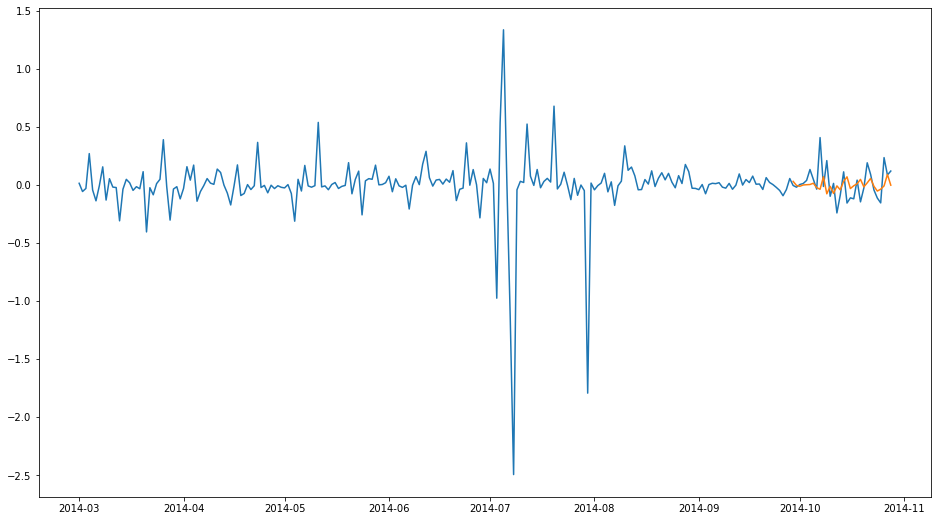

In [76]:
predict=arima.predict(start='2014-09-29', end='2014-10-28', typs = 'levels')
#predict=arima.predict(start='2014-10-28', end='2014-11-15', typs = 'levels')
#predict=arima.predict(typs = 'levels')
#predict = pd.DataFrame(predict, index = test.index, columns=['compound'])
#yhat = arima.forecast(steps=30)
plt.figure(figsize=(16,9))
#plt.plot(test)
plt.plot(df_avg['avg_weighted'])
plt.plot(predict)

#lt.plot(yhat)

In [60]:
lista=[]
for i in range(0,2):
    lista.append(df_avg['avg_weighted'][-i])
sum(lista)

0.13267482006745593